In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils import *

In [4]:
random.seed(2024)

In [5]:
data_dir=f'../raw_data/twitter15'
filename=f'../raw_data/twitter15/twitter15_single_aff.csv'
fig_dir=f'../raw_data/fig'

In [ ]:
import os
import pandas as pd

# Define the directory and output file name
directory = "../raw_data/pheme"
output_file = "../raw_data/pheme/pheme_single.csv"

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over files in the directory
for file_name in os.listdir(directory):
    # Check if the file is a CSV and does not start with 'all'
    if file_name.endswith('.csv') and not file_name.startswith('all'):
        # Construct the full file path
        file_path = os.path.join(directory, file_name)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False)

print(f"All relevant CSV files in '{directory}' merged into '{output_file}'.")

# sentiment & emotion distribution

## sentiment/emotion distribution of source tweets
- select only source tweets
- plot n_comments distribution across all source tweets
- filter out source tweets with more than n_comments
- plot histogram of emotion & valence (concatenate them all and flatten them), so we get two lists for rumour & non-rumour separately

In [16]:
# filter source tweet with more than N comments
n_comments=0

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df=df[~df['structure'].str.endswith('reaction')]
df['structure']=df['structure'].apply(lambda x: collect_keys(x))
df['n_comments']=df['structure'].apply(lambda x: len(x))
# filter tweets with at least n_comments
df=df[df['n_comments']>=n_comments]

In [17]:
# source tweet sentiment distribution
rumour=df[df['rumour_type']=='rumours']
non_rumour=df[df['rumour_type']=='non-rumours']
true=rumour[rumour['factuality']=='true']
false=rumour[rumour['factuality']=='false']
unverified=rumour[rumour['factuality']=='unverified']

# sample true, false and unverified
sample_m=min(len(true),len(false),len(unverified))
true=true.sample(sample_m,random_state=2024)
false=false.sample(sample_m,random_state=2024)
unverified=unverified.sample(sample_m,random_state=2024)
print(f"true rumour size:{len(true)}")
print(f"false rumour size:{len(false)}")
print(f"unverified rumour size:{len(unverified)}")
print()

# sample rumour vs non-rumour
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

true rumour size:359
false rumour size:359
unverified rumour size:359

rumour size:372
non rumour size:372


In [18]:
print(f"average sentiment for rumour:{rumour['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour:{non_rumour['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour:{true['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour:{false['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour:{unverified['emollm_sentiment'].mean()}")

average sentiment for rumour:-0.260752688172043
average sentiment for non rumour:-0.010752688172043012
average sentiment for true rumour:-0.2116991643454039
average sentiment for false rumour:-0.1977715877437326
average sentiment for unverified rumour:-0.3426183844011142


In [19]:
# conduct p-test for average sentiment
pairs=[
    (rumour['emollm_sentiment'],non_rumour['emollm_sentiment']),
    (false['emollm_sentiment'],true['emollm_sentiment']),
    (unverified['emollm_sentiment'], true['emollm_sentiment']),
    (unverified['emollm_sentiment'], false['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true['emollm_sentiment'], false['emollm_sentiment'], unverified['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -3.9979441056689375, P-value: 3.5141695308577907e-05
T-statistic: 0.23726114011112417, P-value: 0.5937389616546603
T-statistic: -2.1912665467533166, P-value: 0.014377001385499882
T-statistic: -2.3957067641464533, P-value: 0.008422066758188525

true, false, unverified rumour sentiment ANOVA:
F-statistic: 3.5905287274145334, P-value: 0.027915356236861304


In [20]:
rumour_emotion = sorted(sum(rumour['emollm_emotion'].apply(process_emotion), []))
non_rumour_emotion = sorted(sum(non_rumour['emollm_emotion'].apply(process_emotion), []))
true_emotion = sorted(sum(true['emollm_emotion'].apply(process_emotion), []))
false_emotion = sorted(sum(false['emollm_emotion'].apply(process_emotion), []))
unverified_emotion = sorted(sum(unverified['emollm_emotion'].apply(process_emotion), []))

In [21]:
# all_df = sorted(sum(df['emollm_emotion'].apply(process_emotion), []))
# sns_plot2(all_df,size=(16,4),xlabels=EMO,title='all tweets emotion distribution',auto=True)

## sentiment/emotion distribution of source tweets + comments
we have two ways to deal with this:
1. flatten all tweets and comments
2. compute sentiment and emotion per tweet and then aggregate

In [53]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:372
non rumour size:372


In [54]:
df_comments=[]
for i,(index, row) in enumerate(src_tweets.iterrows()):
    # get all comments in the source tweet thread
    structure=row['structure']
    structure_keys = collect_keys(structure,'all')
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread['emollm_emotion']=df_thread['emollm_emotion'].apply(process_emotion)
    
    # aggregate each thread, 
    # get top3 emotion, average sentiment
    all_words = list(itertools.chain.from_iterable(df_thread['emollm_emotion']))
    top_3 = [word for word, count in Counter(all_words).most_common(MOST_COMMON)]
    ave_sentiment=df_thread['emollm_sentiment'].mean()
    
    # compute entropy of emotion and sentiment valence
    # sentiment_entropy=compute_entropy(df_thread['emollm_sentiment'])
    # emotion_entropy=compute_entropy(df_thread['emollm_emotion'])
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                            'emollm_emotion':[top_3],
                            # 'sentiment_entropy':sentiment_entropy,
                            # 'emotion_entropy':emotion_entropy,
                            'rumour_type':df_thread.iloc[0]['rumour_type'],
                            'factuality':df_thread.iloc[0]['factuality'],
                            'emollm_sentiment':ave_sentiment})
    df_comments.append(df_agg)
df_comments=pd.concat(df_comments)

In [55]:
df_comments

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment
0,500377145349521411,"[anger, disgust, neutral, fear, optimism]",rumours,unverified,-0.384615
0,535148463609356288,"[joy, neutral, surprise, optimism, anticipation]",rumours,unverified,0.000000
0,407198255793987584,"[sadness, surprise, pessimism]",rumours,true,-0.357143
0,547525843749470208,"[surprise, joy, disgust, neutral, love]",rumours,unverified,-0.075472
0,551135925862805504,"[joy, disgust, sadness, neutral, optimism]",rumours,true,0.028571
...,...,...,...,...,...
0,687632433483759616,"[neutral, joy, surprise, optimism, anticipation]",non-rumours,non-rumor,0.038462
0,685633217160998912,"[joy, love, optimism, neutral, trust]",non-rumours,non-rumor,0.555556
0,692098463262216192,"[joy, neutral, love, optimism, sadness]",non-rumours,non-rumor,0.722222
0,691006265137299456,"[disgust, anger, joy, neutral, sadness]",non-rumours,non-rumor,-0.539683


In [56]:
# tweet comments (is_rumour)
rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('rumours')]
non_rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('non-rumours')]
print(f"rumour size:{len(rumour_comments)}")
print(f"non rumour size:{len(non_rumour_comments)}")
print()

# tweet comments (factuality)
true_rumour_comments=rumour_comments[rumour_comments['factuality']=='true']
false_rumour_comments=rumour_comments[rumour_comments['factuality']=='false']
unverified_rumour_comments=rumour_comments[rumour_comments['factuality']=='unverified']

sample_p=min(len(true_rumour_comments),len(false_rumour_comments),len(unverified_rumour_comments))
true_rumour_comments=true_rumour_comments.sample(sample_p,random_state=2024)
false_rumour_comments=false_rumour_comments.sample(sample_p,random_state=2024)
unverified_rumour_comments=unverified_rumour_comments.sample(sample_p,random_state=2024)

print(f"true rumour size:{len(true_rumour_comments)}")
print(f"false rumour size:{len(false_rumour_comments)}")
print(f"unverified rumour size:{len(unverified_rumour_comments)}")

rumour size:372
non rumour size:372

true rumour size:114
false rumour size:114
unverified rumour size:114


In [57]:
print(f"average sentiment for rumour comments:{rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour comments:{non_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour comments:{true_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour comments:{false_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour comments:{unverified_rumour_comments['emollm_sentiment'].mean()}")

average sentiment for rumour comments:-0.27604593551360834
average sentiment for non rumour comments:-0.06235902802349593
average sentiment for true rumour comments:-0.24984455861737978
average sentiment for false rumour comments:-0.23925978305549547
average sentiment for unverified rumour comments:-0.33858201603757554


In [58]:
# conduct p-test for average sentiment
pairs=[
    (rumour_comments['emollm_sentiment'],non_rumour_comments['emollm_sentiment']),
    (true_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],true_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true_rumour_comments['emollm_sentiment'], false_rumour_comments['emollm_sentiment'], unverified_rumour_comments['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -6.292118334136147, P-value: 2.6755654816870654e-10
T-statistic: -0.17922673336852366, P-value: 0.42896012516375476
T-statistic: -1.4390798791663333, P-value: 0.07575571438262002
T-statistic: -1.635640682883116, P-value: 0.051653368286712555

true, false, unverified rumour sentiment ANOVA:
F-statistic: 1.62616934113922, P-value: 0.1982119812276556


In [59]:
# tweet comments emotion distribution
rumour_comments_emotion = sorted(sum(rumour_comments['emollm_emotion'], []))
non_rumour_comments_emotion = sorted(sum(non_rumour_comments['emollm_emotion'], []))

# tweet comments emotion distribution
true_rumour_comments_emotion = sorted(sum(true_rumour_comments['emollm_emotion'], []))
false_rumour_comments_emotion = sorted(sum(false_rumour_comments['emollm_emotion'], []))
unverified_rumour_comments_emotion = sorted(sum(unverified_rumour_comments['emollm_emotion'], []))

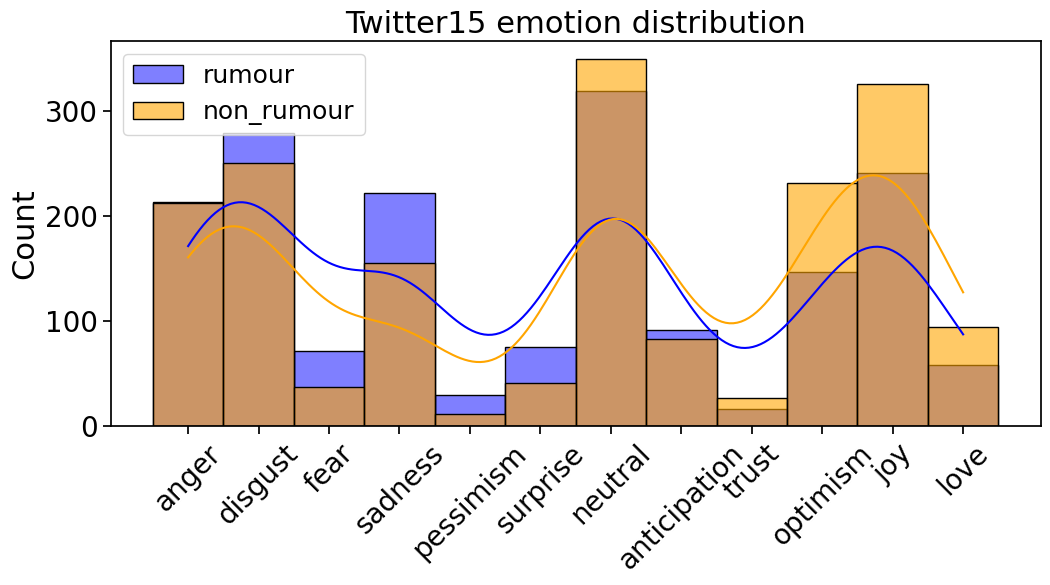

In [60]:
sns_plot2(df1=rumour_comments_emotion,df2=non_rumour_comments_emotion,size=(12,5),font_size=22,xlabels=EMO,
         title='Twitter15 emotion distribution',saveto='twitter15_emotion.pdf')

## sentiment/emotion distribution of comments

In [6]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:372
non rumour size:372


In [7]:
df_comments=[]
for i,(index, row) in tqdm(enumerate(src_tweets.iterrows()),total=len(src_tweets)):
    # get all comments in the source tweet thread
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_comment=df_thread[df_thread['structure'].str.endswith('reaction')] # exclude the root tweet
    df_comment['emollm_emotion']=df_comment['emollm_emotion'].apply(process_emotion)
    
    # aggregate each thread, 
    # get top3 emotion, average sentiment
    all_words = list(itertools.chain.from_iterable(df_comment['emollm_emotion']))
    top_3 = [word for word, count in Counter(all_words).most_common(MOST_COMMON)]
    ave_sentiment=df_thread['emollm_sentiment'][1:].mean()
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                            'emollm_emotion':[top_3],
                            'rumour_type':df_thread.iloc[0]['rumour_type'],
                            'factuality':df_thread.iloc[0]['factuality'],
                            'emollm_sentiment':ave_sentiment})
    df_comments.append(df_agg)
df_comments=pd.concat(df_comments)

100%|████████████████████████████████████████████████████████| 744/744 [00:01<00:00, 495.89it/s]


In [8]:
df_comments['emollm_sentiment'].fillna(0,inplace=True)
df_comments[df_comments['emollm_sentiment'].isna()==True]

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment


In [9]:
df_comments

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment
0,500377145349521411,"[anger, disgust, neutral, optimism, joy]",rumours,unverified,-0.250000
0,535148463609356288,"[joy, neutral, surprise, optimism, anticipation]",rumours,unverified,0.000000
0,407198255793987584,"[sadness, surprise, pessimism]",rumours,true,-0.384615
0,547525843749470208,"[surprise, joy, disgust, neutral, love]",rumours,unverified,-0.076923
0,551135925862805504,"[joy, disgust, sadness, neutral, surprise]",rumours,true,0.029412
...,...,...,...,...,...
0,687632433483759616,"[neutral, joy, surprise, optimism, anticipation]",non-rumours,non-rumor,0.040000
0,685633217160998912,"[joy, love, optimism, neutral, trust]",non-rumours,non-rumor,0.500000
0,692098463262216192,"[joy, neutral, love, optimism, sadness]",non-rumours,non-rumor,0.647059
0,691006265137299456,"[disgust, anger, joy, neutral, sadness]",non-rumours,non-rumor,-0.548387


In [10]:
# tweet comments (is_rumour)
rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('rumours')]
non_rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('non-rumours')]
print(f"rumour size:{len(rumour_comments)}")
print(f"non rumour size:{len(non_rumour_comments)}")
print()

# tweet comments (factuality)
true_rumour_comments=rumour_comments[rumour_comments['factuality']=='true']
false_rumour_comments=rumour_comments[rumour_comments['factuality']=='false']
unverified_rumour_comments=rumour_comments[rumour_comments['factuality']=='unverified']

sample_p=min(len(true_rumour_comments),len(false_rumour_comments),len(unverified_rumour_comments))
true_rumour_comments=true_rumour_comments.sample(sample_p,random_state=2024)
false_rumour_comments=false_rumour_comments.sample(sample_p,random_state=2024)
unverified_rumour_comments=unverified_rumour_comments.sample(sample_p,random_state=2024)

print(f"true rumour size:{len(true_rumour_comments)}")
print(f"false rumour size:{len(false_rumour_comments)}")
print(f"unverified rumour size:{len(unverified_rumour_comments)}")

rumour size:372
non rumour size:372

true rumour size:114
false rumour size:114
unverified rumour size:114


In [11]:
print(f"average sentiment for rumour comments:{rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour comments:{non_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour comments:{true_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour comments:{false_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour comments:{unverified_rumour_comments['emollm_sentiment'].mean()}")

average sentiment for rumour comments:-0.26506800394347113
average sentiment for non rumour comments:-0.05597841782841143
average sentiment for true rumour comments:-0.2386079427562256
average sentiment for false rumour comments:-0.25361968858842
average sentiment for unverified rumour comments:-0.30465113365653873


In [12]:
# conduct p-test for average sentiment
pairs=[
    (rumour_comments['emollm_sentiment'],non_rumour_comments['emollm_sentiment']),
    (true_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'], true_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true_rumour_comments['emollm_sentiment'], false_rumour_comments['emollm_sentiment'], unverified_rumour_comments['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -5.988358730101058, P-value: 1.6507882949214418e-09
T-statistic: 0.2406863248491442, P-value: 0.5949917822340556
T-statistic: -1.0040786222948335, P-value: 0.15820727512135505
T-statistic: -0.790168154480039, P-value: 0.21512894222285034

true, false, unverified rumour sentiment ANOVA:
F-statistic: 0.5805307341197726, P-value: 0.5601566227066497


In [13]:
# tweet comments emotion distribution
rumour_comments_emotion = sorted(sum(rumour_comments['emollm_emotion'], []))
non_rumour_comments_emotion = sorted(sum(non_rumour_comments['emollm_emotion'], []))

# tweet comments emotion distribution
true_rumour_comments_emotion = sorted(sum(true_rumour_comments['emollm_emotion'], []))
false_rumour_comments_emotion = sorted(sum(false_rumour_comments['emollm_emotion'], []))
unverified_rumour_comments_emotion = sorted(sum(unverified_rumour_comments['emollm_emotion'], []))

In [15]:
from utils import *

In [16]:
print_emo_count(rumour_comments_emotion)
print_emo_count(non_rumour_comments_emotion)

negative emotions: 785
positive emotions: 636
neutral: 313

negative emotions: 674
positive emotions: 776
neutral: 349



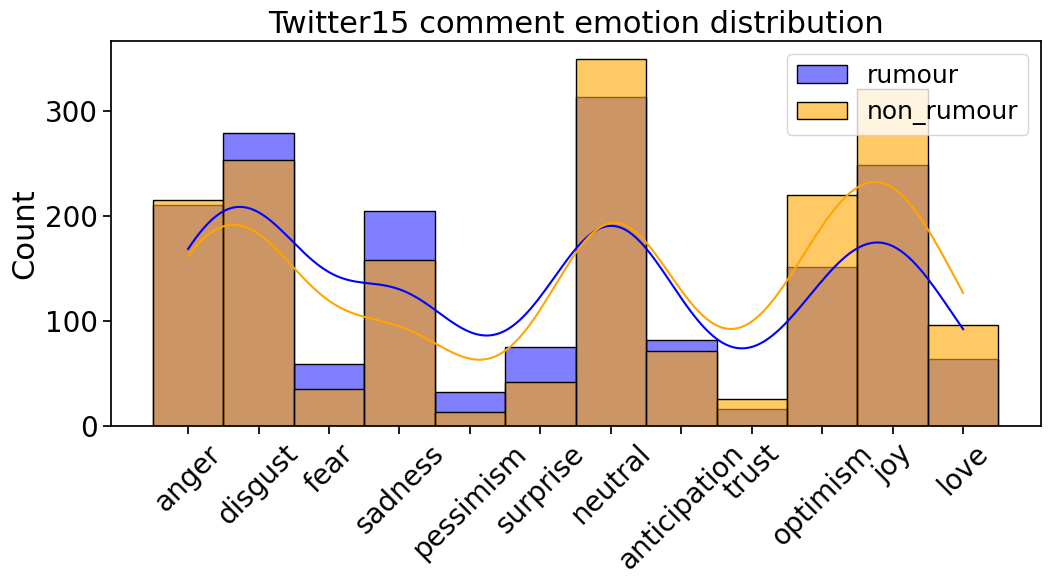

In [71]:
sns_plot2(df1=rumour_comments_emotion,df2=non_rumour_comments_emotion,size=(12,5),font_size=22,xlabels=EMO,
         title='Twitter15 comment emotion distribution',saveto='twitter15_emotion_cmt.pdf')

# emotion stream analysis

In [6]:
# filter source tweet with more than N comments
n_comments=2

df=pd.read_csv(filename,encoding='utf-8')
df['id']=df['id'].astype(str)
df[sentiment_scheme]=df[emotion_scheme].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:372
non rumour size:372


In [7]:
df_comments_original=[]
for i,(index, row) in tqdm(enumerate(src_tweets.iterrows()),total=len(src_tweets)):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread['emollm_emotion']=df_thread['emollm_emotion'].apply(process_emotion)
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                         'timestamp_emotion':[df_thread['emollm_emotion'].to_list()],
                         'rumour_type':df_thread.iloc[0]['rumour_type'],
                         'factuality':df_thread.iloc[0]['factuality'],
                        })
    df_comments_original.append(df_agg)
df_comments=pd.concat(df_comments_original)

100%|██████████████████████████████████████████████████| 744/744 [00:01<00:00, 540.78it/s]


In [8]:
df_comments

,id,timestamp_emotion,rumour_type,factuality
0,500377145349521411,"[[anger, disgust, fear, sadness], [neutral], [...",rumours,unverified
0,535148463609356288,"[[sadness], [joy], [anticipation, joy, surpris...",rumours,unverified
0,407198255793987584,"[[sadness], [sadness], [sadness, surprise], [s...",rumours,true
0,547525843749470208,"[[surprise], [neutral], [neutral], [surprise],...",rumours,unverified
0,551135925862805504,"[[optimism], [disgust, joy, sadness, surprise]...",rumours,true
...,...,...,...,...
0,687632433483759616,"[[neutral], [anger, joy, surprise], [neutral],...",non-rumours,non-rumor
0,685633217160998912,"[[joy, love], [joy, optimism], [joy, love, opt...",non-rumours,non-rumor
0,692098463262216192,"[[joy, optimism], [joy, optimism], [sadness], ...",non-rumours,non-rumor
0,691006265137299456,"[[neutral], [neutral], [disgust, sadness], [an...",non-rumours,non-rumor


In [9]:
# group each thread emotion according to time interval
# each row in df_comments is a thread
df_comments['interval_emotion'] = df_comments.apply(
    lambda row: calculate_interval_emotions(row['timestamp_emotion'], 1), axis=1)

In [10]:
# select thread with at least n_intervals, so far we choose n_intervals=4
n_intervals=15
accum=True
df_time=df_comments[df_comments['interval_emotion'].apply(len)>=n_intervals]
df_time['interval_cnt']=df_time['interval_emotion'].apply(lambda row: count_interval_number(row)).apply(lambda row: cut_list(row,n_intervals))

In [11]:
rumour, non_rumour=get_labeled(df_time,True)
rumour_interval_emotions=get_timestep_emotions(rumour,n_intervals,'interval_emotion')
non_rumour_interval_emotions=get_timestep_emotions(non_rumour,n_intervals,'interval_emotion')

rumour size:189
non rumour size:189


In [12]:
from utils import *

<Figure size 1000x600 with 0 Axes>

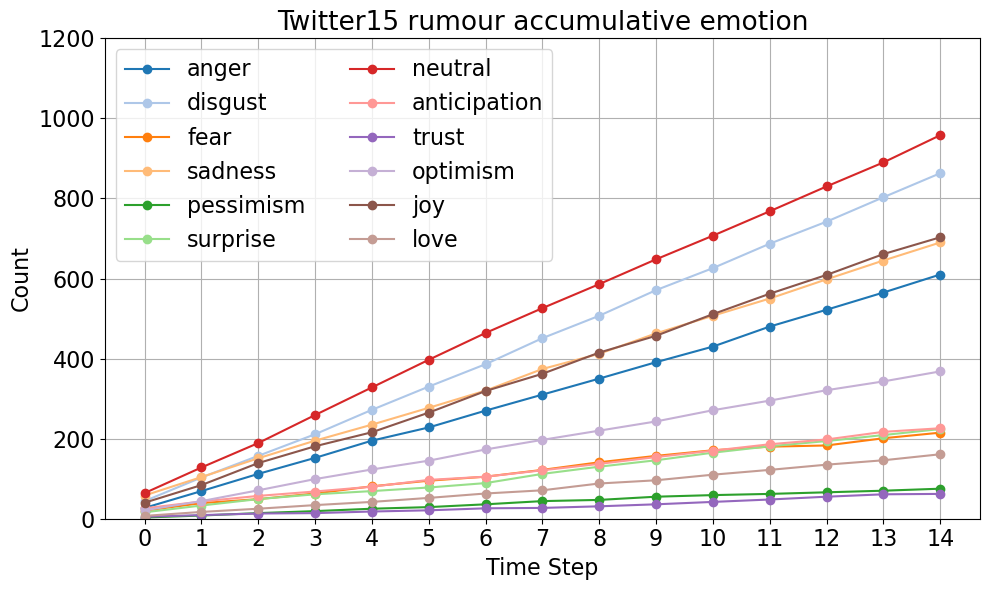

<Figure size 1000x600 with 0 Axes>

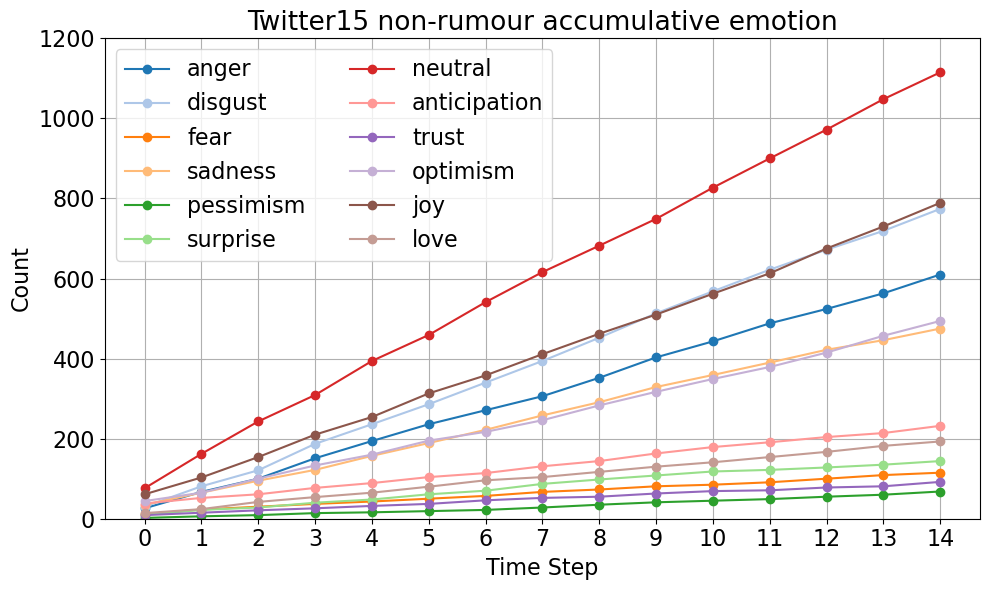

In [13]:
ru_acum=line_plot(rumour_interval_emotions,xlabel='Time Step',ylabel='Count',accum=accum,n_minutes=None, ylim=(0,1200),
          title=f'Twitter15 rumour accumulative emotion',saveto=f'emotion_accumulative/twitter15_rumour_accumulative.pdf')
non_acum=line_plot(non_rumour_interval_emotions,xlabel='Time Step',ylabel='Count',accum=accum,n_minutes=None, ylim=(0,1200),
          title=f'Twitter15 non-rumour accumulative emotion',saveto=f'emotion_accumulative/twitter15_non_accumulative.pdf')

In [14]:
# Combine rumour and non-rumour data into one DataFrame
def create_df(data, condition):
    emotion_data = []
    for emotion, values in data.items():
        emotion_data.append(pd.DataFrame({
            'x': values['x'],
            'y': values['y'],
            'emotion': emotion,
            'Condition': condition
        }))
    return pd.concat(emotion_data, ignore_index=True)

In [15]:
# Create DataFrames for rumour and non-rumour
ru_acum_df = create_df(ru_acum, 'rumour')
non_acum_df = create_df(non_acum, 'non-rumour')

# Combine rumour and non-rumour DataFrames
acum_df = pd.concat([ru_acum_df, non_acum_df], ignore_index=True)

# Create interaction term: x * Condition (1 if rumour, 0 if non-rumour)
acum_df['Condition'] = acum_df['Condition'].map({'rumour': 1, 'non-rumour': 0})
acum_df['x*Condition'] = acum_df['x'] * acum_df['Condition']

In [16]:
# Fit the model for each emotion
results = {}
for emotion in acum_df['emotion'].unique():
    emotion_data = acum_df[acum_df['emotion'] == emotion]
    
    # Define the independent variables (x, Condition, x*Condition) and dependent variable (y)
    X = emotion_data[['x', 'Condition', 'x*Condition']]
    X = sm.add_constant(X)  # Add constant for intercept
    y = emotion_data['y']
    
    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()
    
    # Store results
    results[emotion] = model.summary()

In [17]:
# Print results for each emotion
for emotion, result in results.items():
    print(f"Results for {emotion}:\n")
    print(result)
    print("\n" + "="*50 + "\n")

Results for anger:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.480e+04
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           3.95e-42
Time:                        23:34:28   Log-Likelihood:                -86.577
No. Observations:                  30   AIC:                             181.2
Df Residuals:                      26   BIC:                             186.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          23.2500      2.

In [105]:
def print_dict(sample_dict):
    for key,values in sample_dict.items():
        print(key, values)
print_dict(ru_slopes)
print()
print_dict(non_slopes)

anger 41.18
disgust 58.67
fear 13.95
sadness 45.02
pessimism 5.26
surprise 14.94
neutral 63.69
anticipation 14.42
trust 4.16
optimism 24.8
joy 47.65
love 10.97

anger 41.75
disgust 53.42
fear 7.01
sadness 31.97
pessimism 5.28
surprise 9.52
neutral 75.41
anticipation 13.34
trust 5.45
optimism 32.19
joy 51.07
love 12.88


# sentiments & emotion transition
- extract non-root pairwise emotions: return a list of (parent emotion, child emotion)
- extract root pairwise emotions: return a list of (root emotion, first layer node emotions)
- build count-based emotion transition matrix
- build masking emotion

In [6]:
# sentiment_scheme='emollm_sentiment'
emotion_scheme='emollm_emotion'

In [7]:
filename='../raw_data/twitter15/twitter15_single_aff.csv'

In [8]:
# filter source tweet with more than N comments
n_comments=2

df=pd.read_csv(filename,encoding='utf-8')
df['id']=df['id'].astype(str)
df[sentiment_scheme]=df[emotion_scheme].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:372
non rumour size:372


In [9]:
df_comments_original=[]
# thread or time
pairwise_type='time'
n_gram=5
for index, row in tqdm(src_tweets.iterrows(),total=src_tweets.shape[0]):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread=df_thread.drop_duplicates(subset=['id'], keep='first')
    # df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
    # df_thread['created_at']=df_thread['created_at'].apply(format_time)
    # df_thread.sort_values(by='created_at',inplace=True)

    # aggregate information for one thread
    agg_dict={
        'id':df_thread.iloc[0]['id'],
        # 'event':df_thread.iloc[0]['event'],
        'rumour_type':df_thread.iloc[0]['rumour_type'],
        'factuality':df_thread.iloc[0]['factuality'],
    }
    # extract N-gram affective info (the first in N-gram should be aff in source tweet)
    if 'n_gram' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=True)
        n_gram_id=timestamp_n_gram(df_thread['id'].to_list(),n_gram,False)
        n_gram_emo=get_aff_from_id(df_thread,n_gram_id,emotion_scheme)
        agg_dict.update({
            'n_gram_pairs_id':[n_gram_id],
            'n_gram_pairs_emo':[n_gram_emo],
        })

    # extract pair affective info chronologically
    if 'time' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        df_thread=df_thread[df_thread['structure'].str.endswith('reaction')] # exclude the root tweet
        time_pairs_id=timestamp_pairwise(df_thread['id'].to_list())
        time_pairs_emo=get_emo_from_id(df_thread,time_pairs_id)
        time_pairs_emo=product_pairs(time_pairs_emo)
        time_pairs_sent=get_sent_from_id(df_thread,time_pairs_id)
        agg_dict.update({
            'time_pairs_id':[time_pairs_id],
            'time_pairs_emo':[time_pairs_emo],
            'time_pairs_sent':[time_pairs_sent],
        })
        
    # extract pair affective info based on tree structure
    if 'thread' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        # extract pariwise ids, (parent, child) comes from structure
        _, non_root_pairs, root_pairs=bfs_tree_pairwise(structure)
        
        # extract pairwise emotions from ids
        root_pairs_emo=get_emo_from_id(df_thread,root_pairs)
        non_root_pairs_emo=get_emo_from_id(df_thread,non_root_pairs)
        # product pairs
        root_pairs_emo=product_pairs(root_pairs_emo)
        non_root_pairs_emo=product_pairs(non_root_pairs_emo)
    
        # extract pairwise sentiments from ids
        root_pairs_sent=get_sent_from_id(df_thread,root_pairs)
        non_root_pairs_sent=get_sent_from_id(df_thread,non_root_pairs)
        agg_dict.update({
            'root_pairs_id':[root_pairs],
            'non_root_pairs_id':[non_root_pairs],
            'root_pairs_emo':[root_pairs_emo],
            'non_root_pairs_emo':[non_root_pairs_emo],
            'root_pairs_sent':[root_pairs_sent],
            'non_root_pairs_sent':[non_root_pairs_sent],
        })
    
    df_agg=pd.DataFrame(agg_dict)
    df_comments_original.append(df_agg)

100%|█████████████████████████████████████████████████████████| 744/744 [00:09<00:00, 75.81it/s]


In [10]:
df_comments=pd.concat(df_comments_original)

In [11]:
df_comments.head()

,id,rumour_type,factuality,time_pairs_id,time_pairs_emo,time_pairs_sent
0,500377145349521411,rumours,unverified,"[(500377145349521411_1, 500377145349521411_2),...","[(neutral, anger), (neutral, disgust), (neutra...","[( neutral or no emotion., anger, disgust, op..."
0,535148463609356288,rumours,unverified,"[(535148463609356288_1, 535148463609356288_2),...","[(joy, anticipation), (joy, joy), (joy, surpri...","[( joy., anticipation, joy, surprise.), ( ant..."
0,407198255793987584,rumours,true,"[(407198255793987584_1, 407198255793987584_2),...","[(sadness, sadness), (sadness, surprise), (sad...","[( sadness., sadness, surprise.), ( sadness, ..."
0,547525843749470208,rumours,unverified,"[(547525843749470208_1, 547525843749470208_2),...","[(neutral, neutral), (neutral, surprise), (sur...","[( neutral or no emotion., neutral or no emot..."
0,551135925862805504,rumours,true,"[(551135925862805504_1, 551135925862805504_2),...","[(disgust, sadness), (joy, sadness), (sadness,...","[( disgust, joy, sadness, surprise., sadness...."


In [12]:
rumour, non_rumour=get_labeled(df_comments,True)

rumour size:372
non rumour size:372


In [13]:
true, false, unverified= get_factuality(df_comments,True)

true size:114
false size:114
unverified size:114


## emotion transition (time)

In [14]:
from utils import *

In [15]:
# rumour and non rumour emotion
sample_size=0
no_neutral=False
is_log=False
ru_root=get_emo_pairs(rumour,'time_pairs_emo',no_neutral,sample_size)
non_root=get_emo_pairs(non_rumour,'time_pairs_emo',no_neutral,sample_size)

time_pairs_emo pair size: 32316
time_pairs_emo pair size: 40326


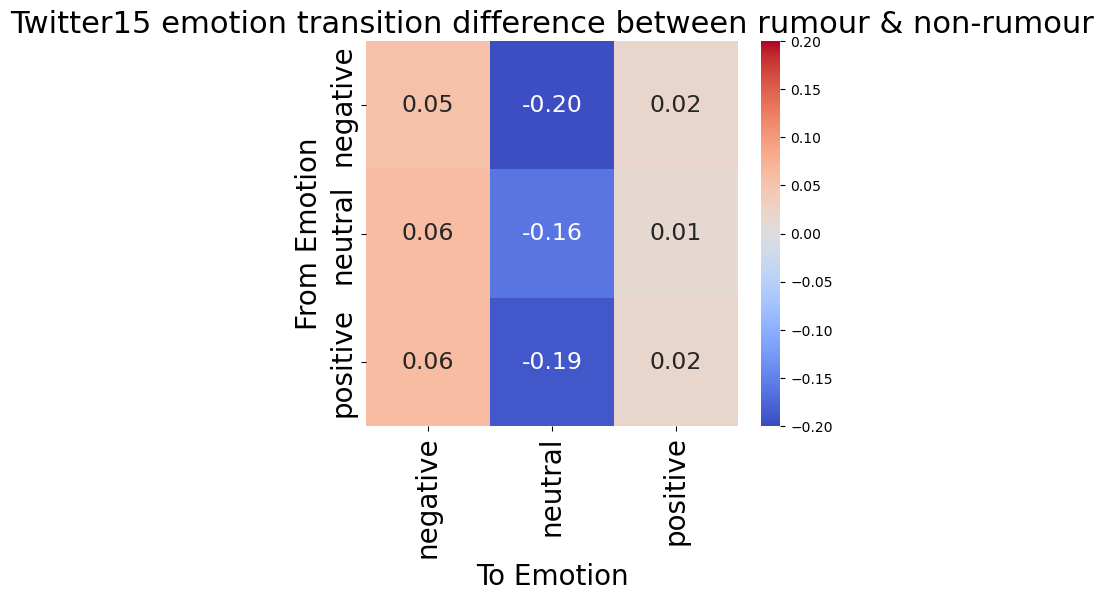

In [35]:
# aggregated emotions
vmax=0.2
vmin=-0.2
font_size=16
_,ru_root_matrix=create_pure_matrix(normalize_emotion_pairs(ru_root),'emo_agg',no_neutral,is_log,'twitter15_rumour_transition',vmax,vmin)
_,non_root_matrix=create_pure_matrix(normalize_emotion_pairs(non_root),'emo_agg',no_neutral,is_log,'twitter15_non_transition',vmax,vmin)
diff_root=(ru_root_matrix-non_root_matrix)/ru_root_matrix

plot_matrix(matrix=diff_root,aff='emo_agg',no_neutral=False,font_size=20,vmax=vmax,vmin=vmin, annot=diff_root, fig_size=(6,5),
            title='Twitter15 emotion transition difference between rumour & non-rumour')

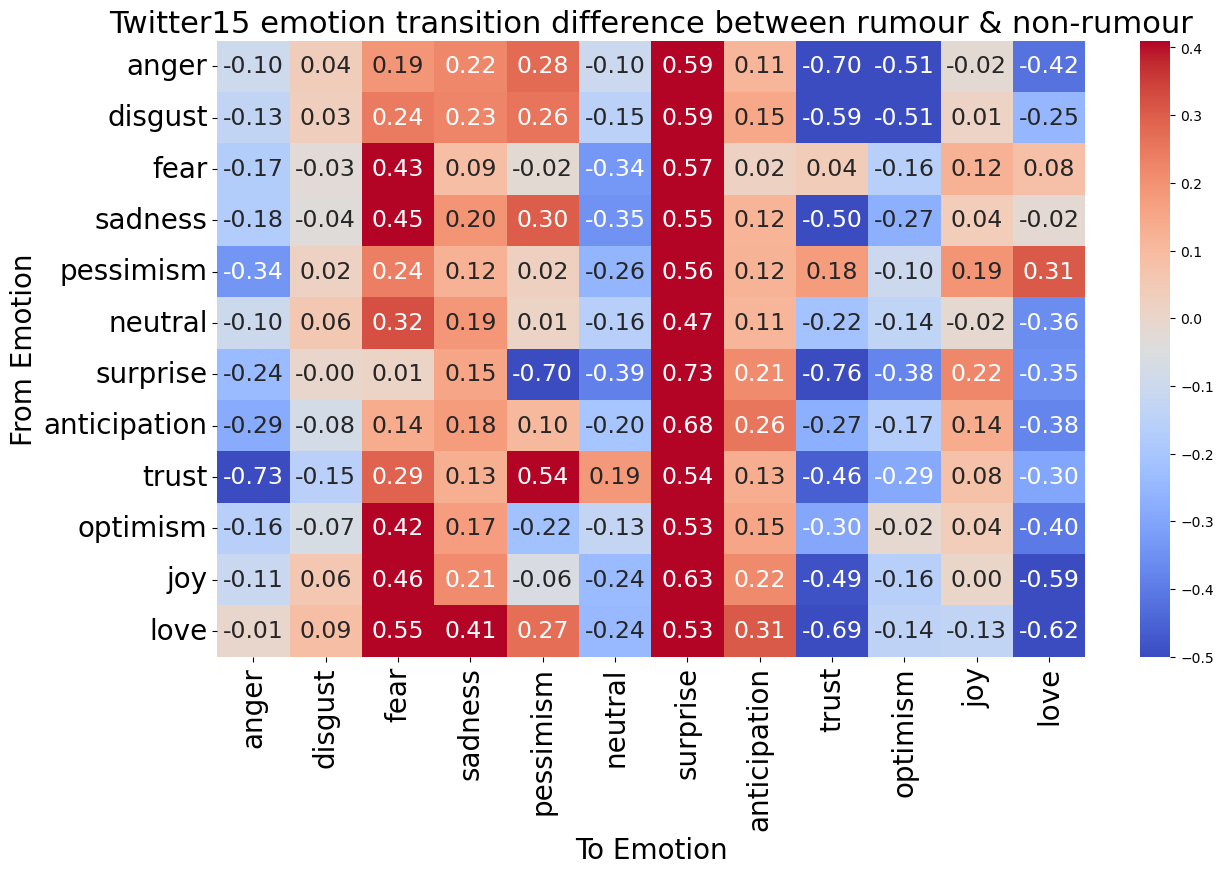

In [17]:
vmax=0.41
vmin=-0.5
font_size=16
_,ru_root_matrix=create_pure_matrix(ru_root,'emo',no_neutral,is_log,'twitter15_rumour_transition',vmax,vmin)
_,non_root_matrix=create_pure_matrix(non_root,'emo',no_neutral,is_log,'twitter15_non_transition',vmax,vmin)
diff_root=(ru_root_matrix-non_root_matrix)/ru_root_matrix

plot_matrix(diff_root,aff='emo',no_neutral=no_neutral,font_size=20,vmax=vmax,vmin=vmin, annot=diff_root,
            title='Twitter15 emotion transition difference between rumour & non-rumour',saveto='twitter15_diff_transition_noroot.pdf')

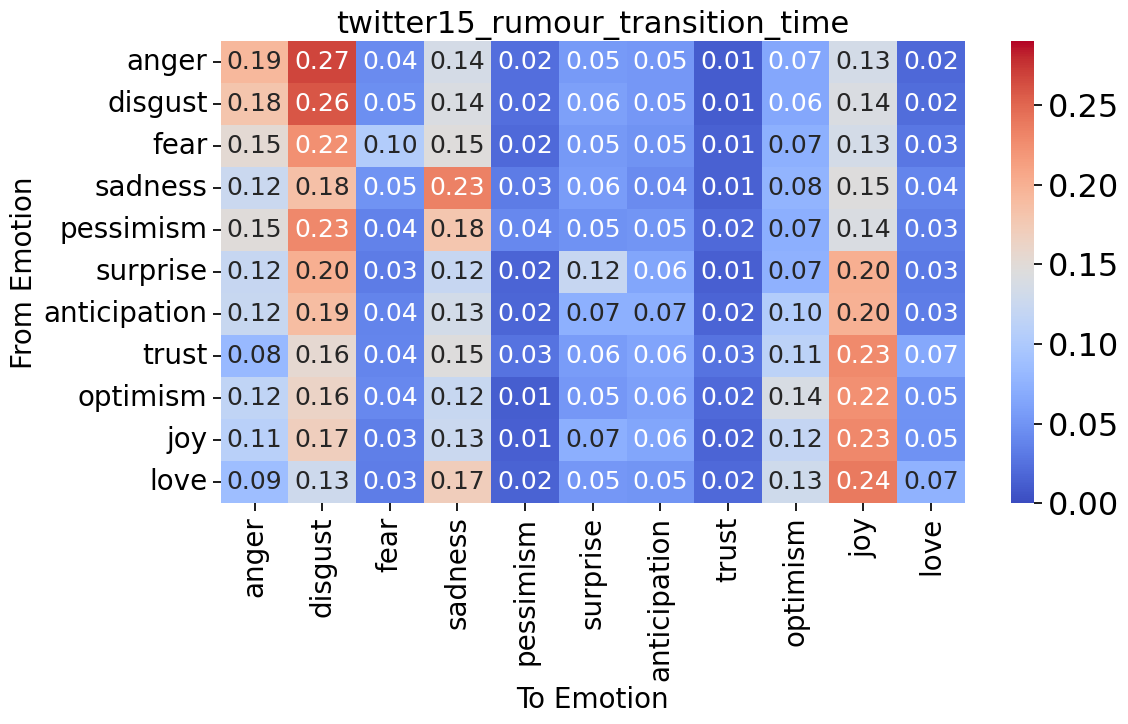

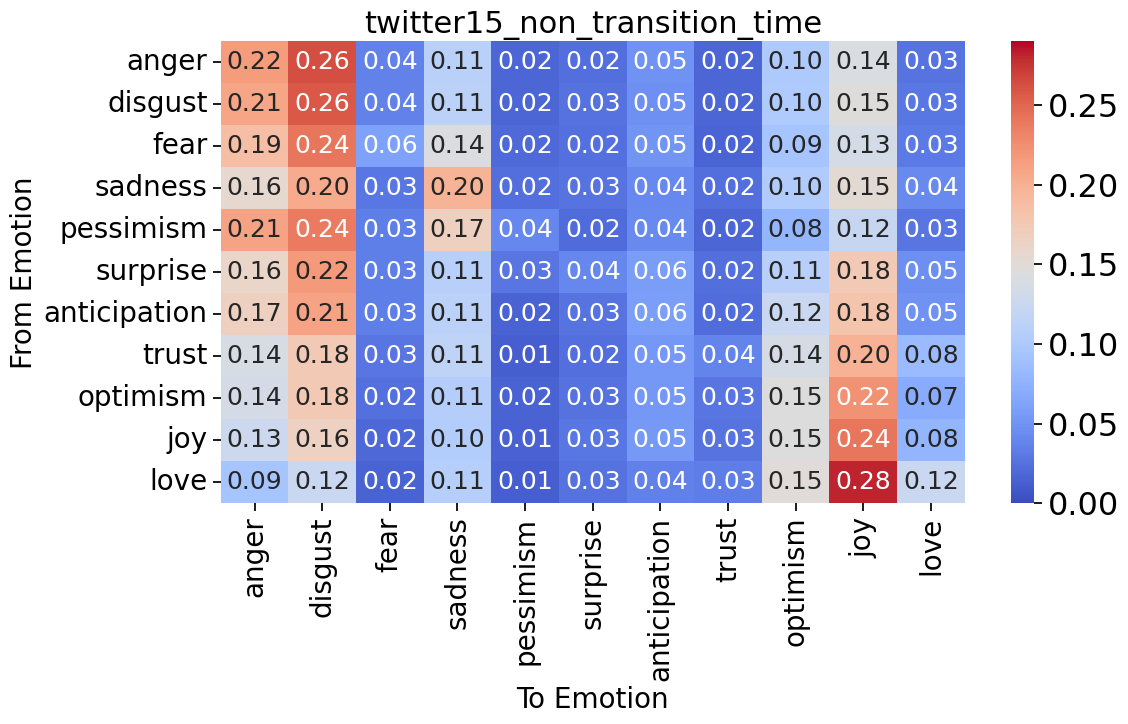

In [68]:
# rumour vs non rumour root
vmax=0.29
vmin=0
font_size=16
create_matrix(ru_root,'emo',no_neutral,is_log,'twitter15_rumour_transition_time',vmax,vmin)
create_matrix(non_root,'emo',no_neutral,is_log,'twitter15_non_transition_time',vmax,vmin)

In [55]:
# sentiment_scheme='emollm_sentiment'
emotion_scheme='emollm_emotion'

In [138]:
# filter source tweet with more than N comments
n_comments=0

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
df[sentiment_scheme]=df[sentiment_scheme].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:372
non rumour size:372


In [157]:
df_comments_original=[]
# thread or time
pairwise_type='thread'
n_gram=5
for index, row in tqdm(src_tweets.iterrows(),total=src_tweets.shape[0]):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread=df_thread.drop_duplicates(subset=['id'], keep='first')
    # df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
    # df_thread['created_at']=df_thread['created_at'].apply(format_time)
    # df_thread.sort_values(by='created_at',inplace=True)

    # aggregate information for one thread
    agg_dict={
        'id':df_thread.iloc[0]['id'],
        # 'event':df_thread.iloc[0]['event'],
        'rumour_type':df_thread.iloc[0]['rumour_type'],
        'factuality':df_thread.iloc[0]['factuality'],
    }
    # extract N-gram affective info (the first in N-gram should be aff in source tweet)
    if 'n_gram' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=True)
        n_gram_id=timestamp_n_gram(df_thread['id'].to_list(),n_gram,False)
        n_gram_emo=get_aff_from_id(df_thread,n_gram_id,emotion_scheme)
        agg_dict.update({
            'n_gram_pairs_id':[n_gram_id],
            'n_gram_pairs_emo':[n_gram_emo],
        })

    # extract pair affective info chronologically
    if 'time' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        time_pairs_id=timestamp_pairwise(df_thread['id'].to_list())
        time_pairs_emo=get_emo_from_id(df_thread,time_pairs_id)
        time_pairs_emo=product_pairs(time_pairs_emo)
        time_pairs_sent=get_sent_from_id(df_thread,time_pairs_id)
        agg_dict.update({
            'time_pairs_id':[time_pairs_id],
            'time_pairs_emo':[time_pairs_emo],
            'time_pairs_sent':[time_pairs_sent],
        })
        
    # extract pair affective info based on tree structure
    if 'thread' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        # extract pariwise ids, (parent, child) comes from structure
        _, non_root_pairs, root_pairs=bfs_tree_pairwise(structure)
        
        # extract pairwise emotions from ids
        root_pairs_emo=get_emo_from_id(df_thread,root_pairs)
        non_root_pairs_emo=get_emo_from_id(df_thread,non_root_pairs)
        # product pairs
        root_pairs_emo=product_pairs(root_pairs_emo)
        non_root_pairs_emo=product_pairs(non_root_pairs_emo)
    
        # extract pairwise sentiments from ids
        root_pairs_sent=get_sent_from_id(df_thread,root_pairs)
        non_root_pairs_sent=get_sent_from_id(df_thread,non_root_pairs)
        agg_dict.update({
            'root_pairs_id':[root_pairs],
            'non_root_pairs_id':[non_root_pairs],
            'root_pairs_emo':[root_pairs_emo],
            'non_root_pairs_emo':[non_root_pairs_emo],
            'root_pairs_sent':[root_pairs_sent],
            'non_root_pairs_sent':[non_root_pairs_sent],
        })
    
    df_agg=pd.DataFrame(agg_dict)
    df_comments_original.append(df_agg)
df_comments=pd.concat(df_comments_original)

100%|█████████████████████████████████████████████████████████| 744/744 [00:10<00:00, 73.66it/s]


In [158]:
df_comments.head()

,id,rumour_type,factuality,root_pairs_id,non_root_pairs_id,root_pairs_emo,non_root_pairs_emo,root_pairs_sent,non_root_pairs_sent
0,500377145349521411,rumours,unverified,"[[500377145349521411, 500377145349521411_1], [...",[],"[(anger, neutral), (disgust, neutral), (fear, ...",[],"[( anger, disgust, fear, sadness., neutral or...",[]
0,535148463609356288,rumours,unverified,"[[535148463609356288, 535148463609356288_1], [...",[],"[(sadness, joy), (sadness, anticipation), (sad...",[],"[( sadness., joy.), ( sadness., anticipation...",[]
0,407198255793987584,rumours,true,"[[407198255793987584, 407198255793987584_1], [...",[],"[(sadness, sadness), (sadness, sadness), (sadn...",[],"[( sadness., sadness.), ( sadness., sadness,...",[]
0,547525843749470208,rumours,unverified,"[[547525843749470208, 547525843749470208_1], [...",[],"[(surprise, neutral), (surprise, neutral), (su...",[],"[( surprise., neutral or no emotion.), ( surp...",[]
0,551135925862805504,rumours,true,"[[551135925862805504, 551135925862805504_1], [...",[],"[(optimism, disgust), (optimism, joy), (optimi...",[],"[( optimism., disgust, joy, sadness, surprise...",[]


In [159]:
rumour, non_rumour=get_labeled(df_comments,True)
true, false, unverified= get_factuality(df_comments,True)

rumour size:372
non rumour size:372
true size:114
false size:114
unverified size:114


In [160]:
# rumour and non rumour emotion
sample_size=0
no_neutral=True
is_log=False
ru_root=get_sent_pairs(rumour,'root_pairs_sent',sample_size)
ru_branch=get_sent_pairs(rumour,'non_root_pairs_sent',sample_size)
non_root=get_sent_pairs(non_rumour,'root_pairs_sent',sample_size)
non_branch=get_sent_pairs(non_rumour,'non_root_pairs_sent',sample_size)

root_pairs_sent pair size: 9951
non_root_pairs_sent pair size: 0
root_pairs_sent pair size: 12499
non_root_pairs_sent pair size: 0


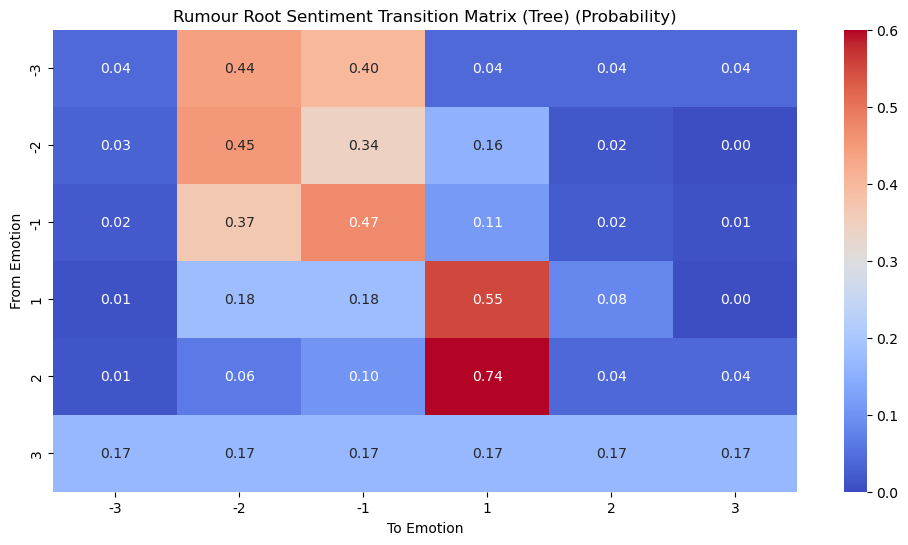

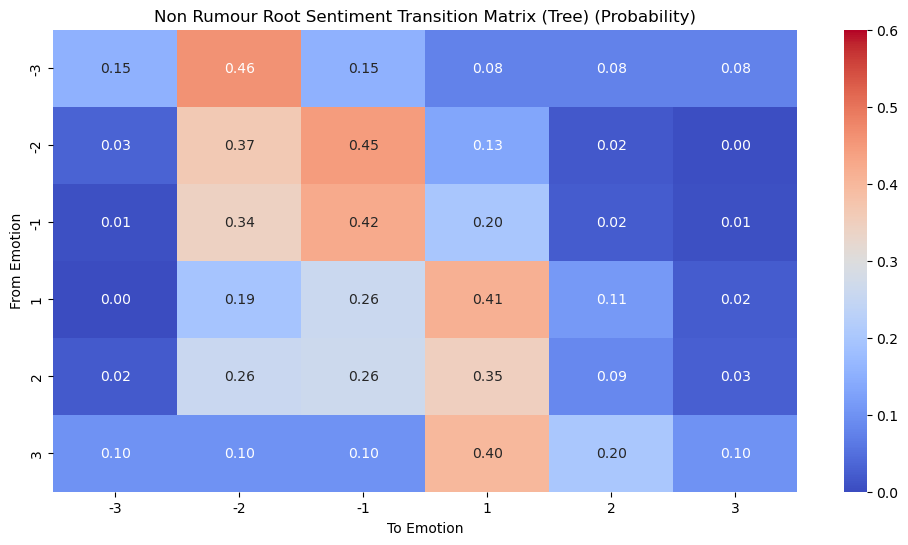

In [151]:
# rumour vs non rumour root
vmax=0.60
vmin=0
create_matrix(ru_root,'sent',no_neutral,is_log,'Rumour Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(non_root,'sent',no_neutral,is_log,'Non Rumour Root Sentiment Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# rumour vs non rumour branch
create_matrix(ru_branch,'sent',no_neutral,is_log,'Rumour Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(non_branch,'sent',no_neutral,is_log,'Non Rumour Branch Sentiment Transition Matrix (Tree)',vmax,vmin)

In [137]:
# true, false and unverified emotion
sample_size=0
true_root=get_sent_pairs(true,pair_type='root_pairs_sent',n_sample=sample_size)
false_root=get_sent_pairs(false,pair_type='root_pairs_sent',n_sample=sample_size)
unverified_root=get_sent_pairs(unverified,pair_type='root_pairs_sent',n_sample=sample_size)

true_branch=get_sent_pairs(true,pair_type='non_root_pairs_sent',n_sample=sample_size)
false_branch=get_sent_pairs(false,pair_type='non_root_pairs_sent',n_sample=sample_size)
unverified_branch=get_sent_pairs(unverified,pair_type='non_root_pairs_sent',n_sample=sample_size)

root_pairs_sent pair size: 385
root_pairs_sent pair size: 399
root_pairs_sent pair size: 397
non_root_pairs_sent pair size: 0
non_root_pairs_sent pair size: 0
non_root_pairs_sent pair size: 0


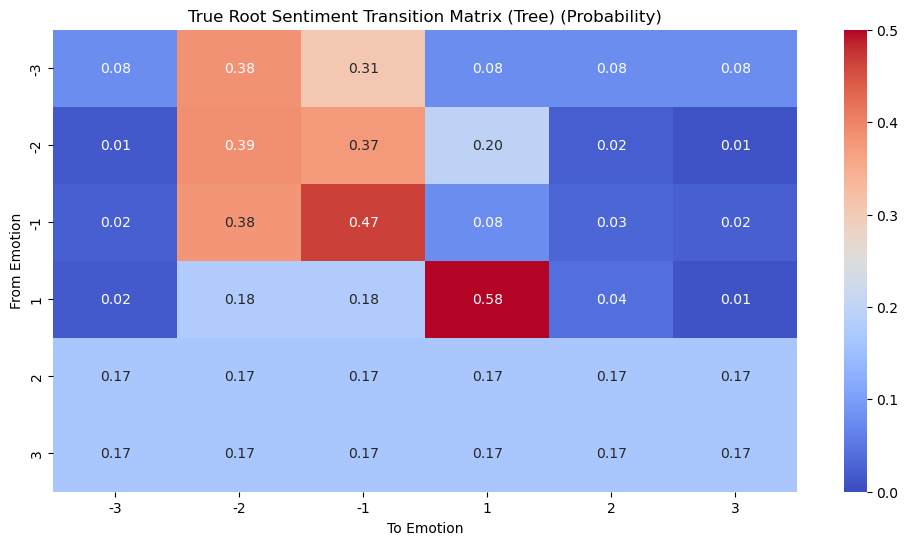

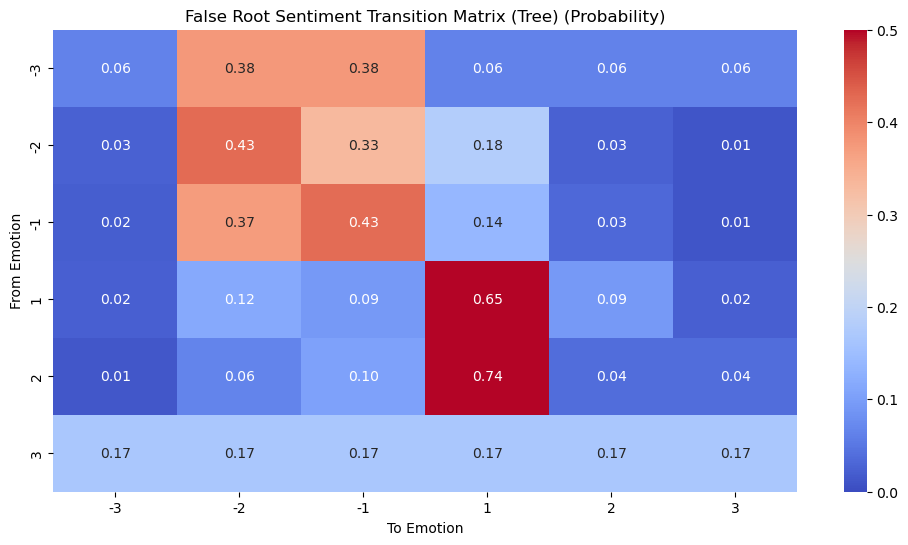

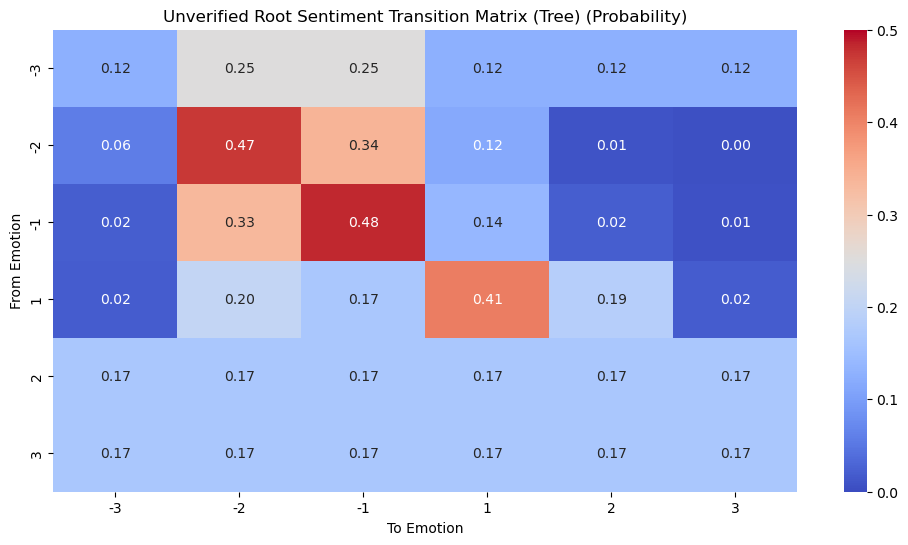

In [139]:
# true, false and unverified root
vmax=0.5
vmin=0
create_matrix(true_root,'sent',no_neutral,is_log,'True Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_root,'sent',no_neutral,is_log,'False Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_root,'sent',no_neutral,is_log,'Unverified Root Sentiment Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# true, false and unverified branch
vmax=0.65
create_matrix(true_branch,'sent',no_neutral,is_log,'True Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_branch,'sent',no_neutral,is_log,'False Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_branch,'sent',no_neutral,is_log,'Unverified Branch Sentiment Transition Matrix (Tree)',vmax,vmin)

## emotion transition (tree)

In [127]:
# rumour and non rumour emotion
sample_size=0
no_neutral=True
is_log=False
ru_root=get_emo_pairs(rumour,'root_pairs_emo',no_neutral,sample_size)
ru_branch=get_emo_pairs(rumour,'non_root_pairs_emo',no_neutral,sample_size)
non_root=get_emo_pairs(non_rumour,'root_pairs_emo',no_neutral,sample_size)
non_branch=get_emo_pairs(non_rumour,'non_root_pairs_emo',no_neutral,sample_size)

root_pairs_emo pair size: 22669
non_root_pairs_emo pair size: 0
root_pairs_emo pair size: 30413
non_root_pairs_emo pair size: 0


In [128]:
from utils import *

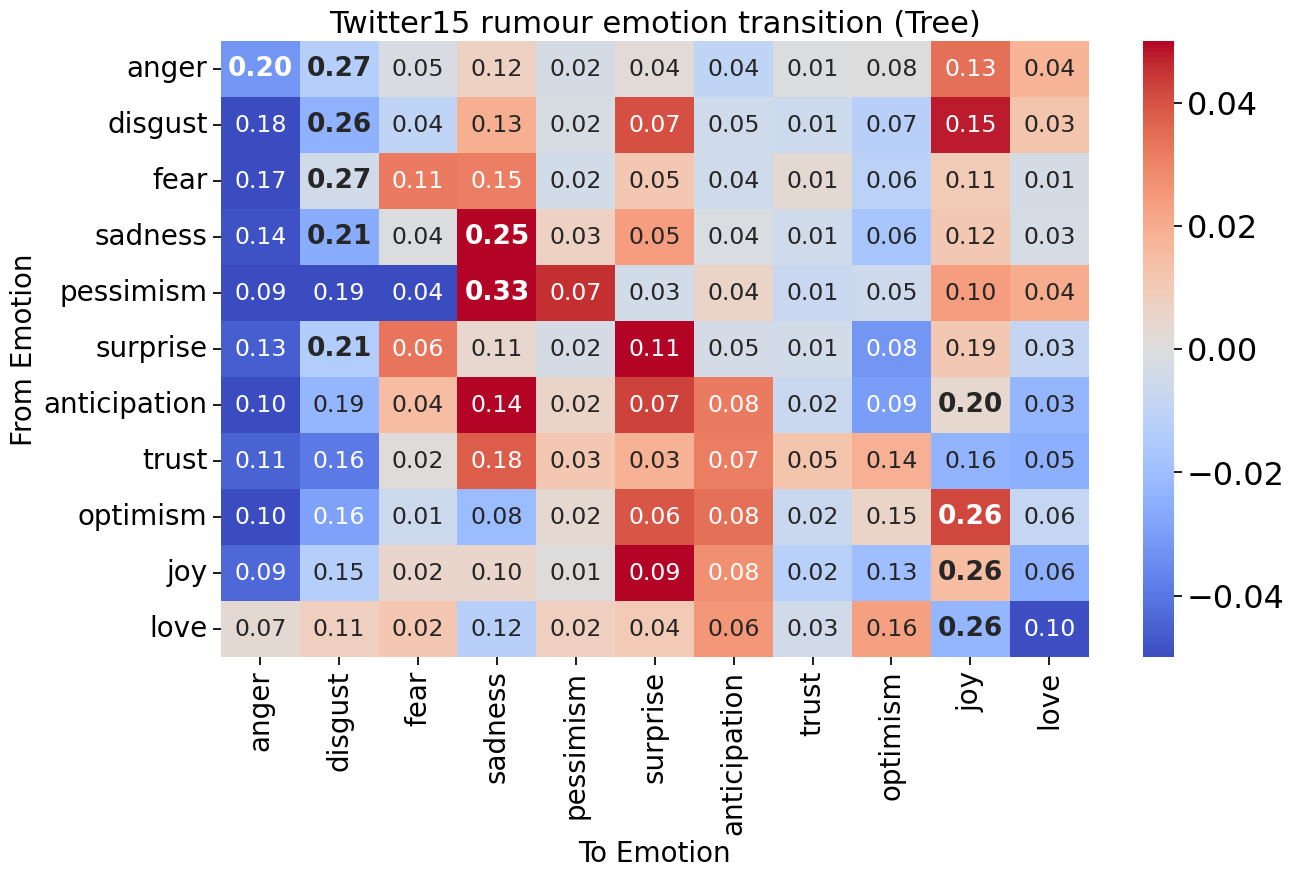

In [129]:
vmax=0.05
vmin=-0.05
font_size=16
all_ru=ru_root+ru_branch
all_non=non_root+non_branch

_,ru_matrix=create_pure_matrix(all_ru,'emo',no_neutral,is_log,'twitter15_rumour_transition',vmax,vmin)
_,non_matrix=create_pure_matrix(all_non,'emo',no_neutral,is_log,'twitter15_non_transition',vmax,vmin)

diff=ru_matrix-non_matrix


plot_matrix(matrix=diff,aff='emo',no_neutral=True,font_size=20,vmax=vmax,vmin=vmin, annot=ru_matrix,
            title='Twitter15 rumour emotion transition (Tree)',saveto='twitter15_diff_transition_tree_delta.pdf')

# plot_matrix(matrix=ru_matrix,aff='emo',no_neutral=True,font_size=20,vmax=vmax,vmin=vmin, annot=diff,
#             title='Twitter15 rumour emotion transition (Tree)',saveto='twitter15_diff_transition_tree_origin.pdf')

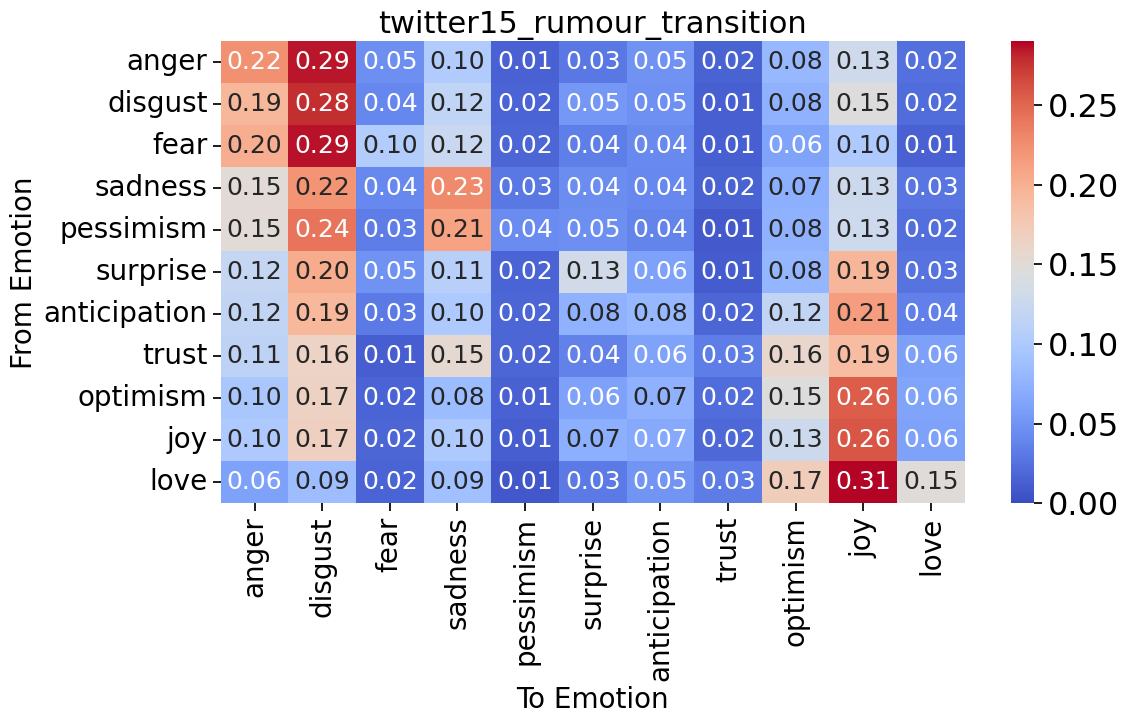

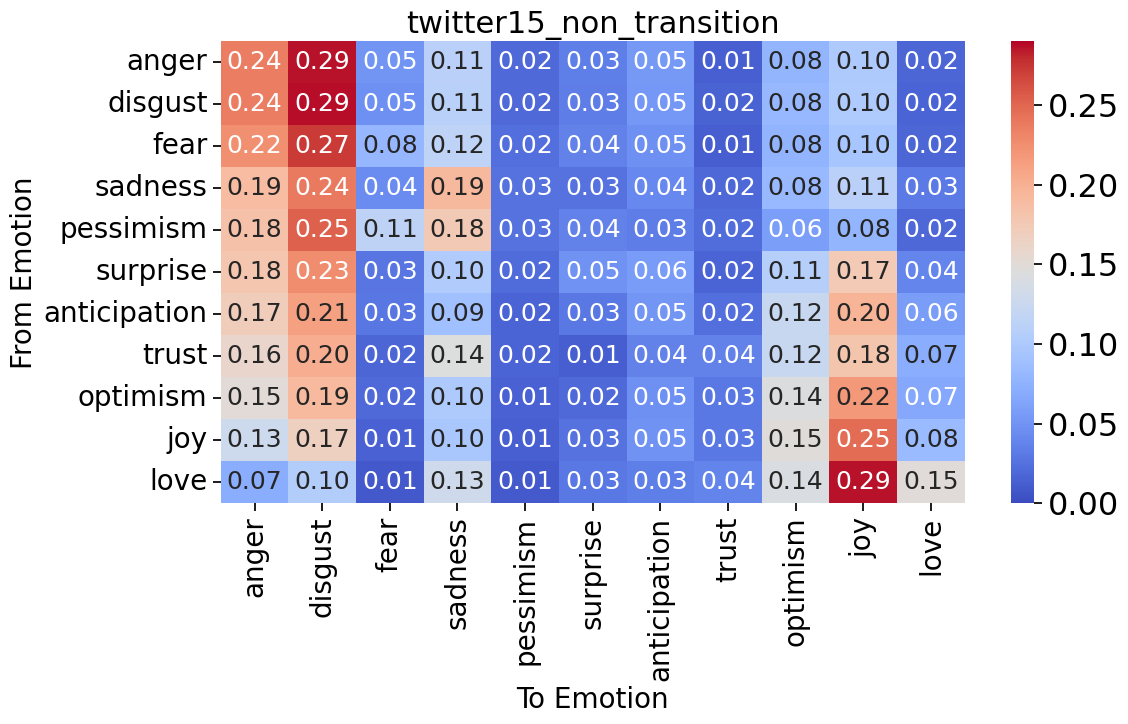

In [96]:
# rumour vs non rumour root
vmax=0.29
vmin=0
font_size=16
create_matrix(ru_root,'emo',no_neutral,is_log,'twitter15_rumour_transition',vmax,vmin)
create_matrix(non_root,'emo',no_neutral,is_log,'twitter15_non_transition',vmax,vmin)

In [ ]:
# rumour vs non rumour branch
vmax=0.32
create_matrix(ru_branch,'emo',no_neutral,is_log,'twitter15_rumour_transition_branch',vmax,vmin)
create_matrix(non_branch,'emo',no_neutral,is_log,'twitter15_non_transition_branch',vmax,vmin)

In [59]:
# true, false and unverified emotion
sample_size=0
true_root=get_emo_pairs(true,pair_type='root_pairs_emo',n_sample=sample_size)
false_root=get_emo_pairs(false,pair_type='root_pairs_emo',n_sample=sample_size)
unverified_root=get_emo_pairs(unverified,pair_type='root_pairs_emo',n_sample=sample_size)

true_branch=get_emo_pairs(true,pair_type='non_root_pairs_emo',n_sample=sample_size)
false_branch=get_emo_pairs(false,pair_type='non_root_pairs_emo',n_sample=sample_size)
unverified_branch=get_emo_pairs(unverified,pair_type='non_root_pairs_emo',n_sample=sample_size)

root_pairs_emo pair size: 5222
root_pairs_emo pair size: 11321
root_pairs_emo pair size: 4866
non_root_pairs_emo pair size: 0
non_root_pairs_emo pair size: 0
non_root_pairs_emo pair size: 0


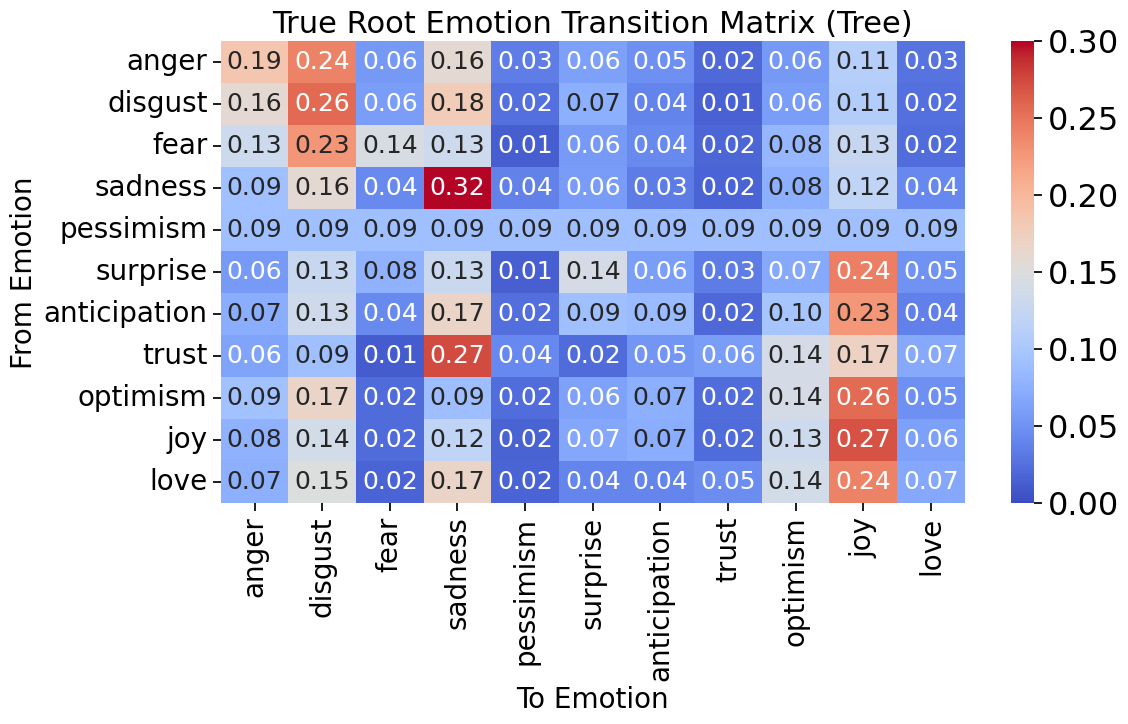

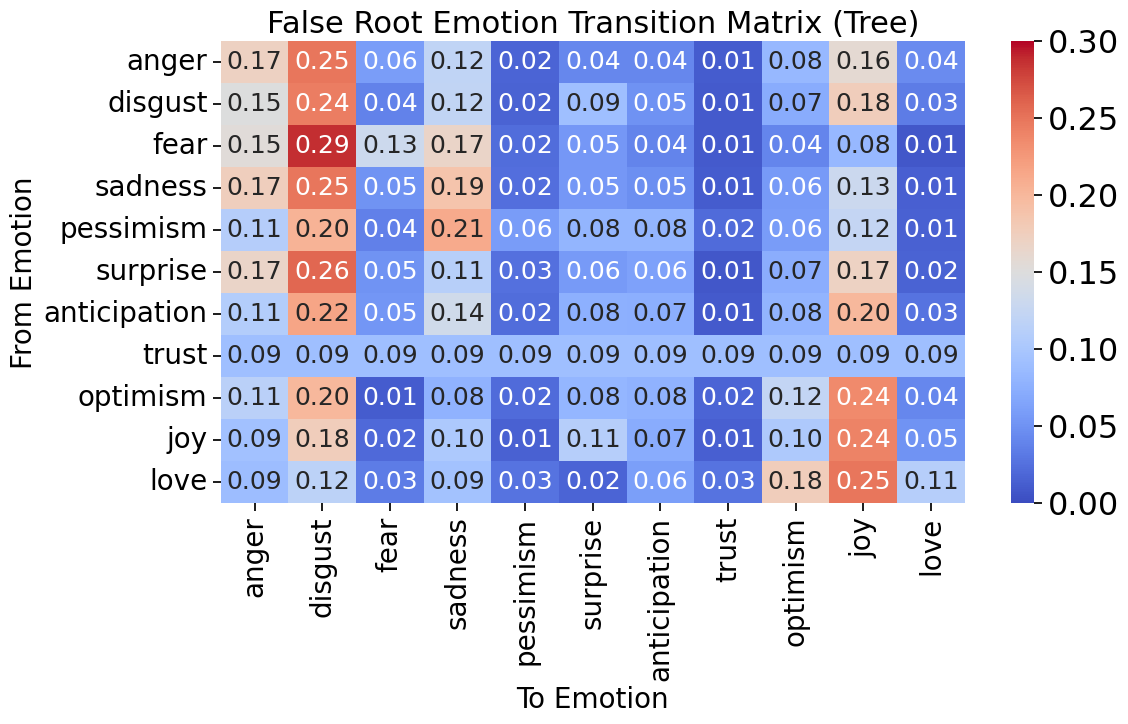

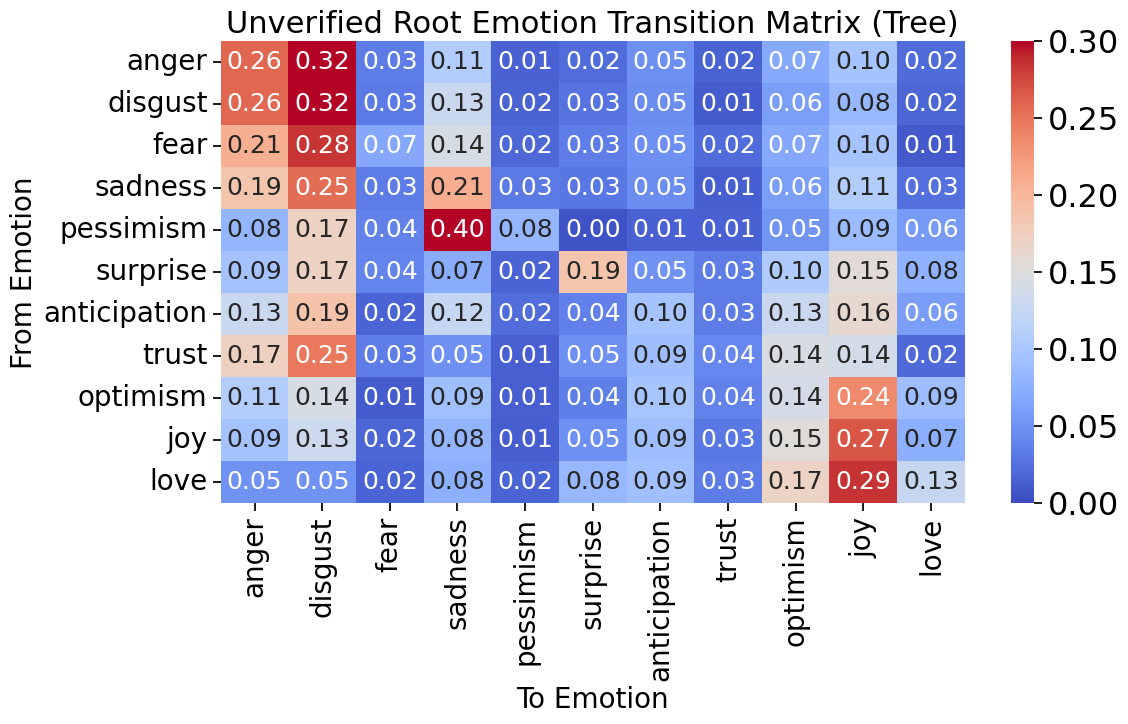

In [60]:
# true, false and unverified root
vmax=0.30
create_matrix(true_root,'emo',no_neutral,is_log,'True Root Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_root,'emo',no_neutral,is_log,'False Root Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_root,'emo',no_neutral,is_log,'Unverified Root Emotion Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# currently no branch info for twitter15
# true, false and unverified branch
# vmax=0.32
# create_matrix(true_branch,'emo',no_neutral,is_log,'True Branch Emotion Transition Matrix (Tree)',vmax,vmin)
# create_matrix(false_branch,'emo',no_neutral,is_log,'False Branch Emotion Transition Matrix (Tree)',vmax,vmin)
# create_matrix(unverified_branch,'emo',no_neutral,is_log,'Unverified Branch Emotion Transition Matrix (Tree)',vmax,vmin)

# Test